In [2]:
import os

from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from keras.models import Model, load_model
from keras.saving import register_keras_serializable
import keras

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import cv2

In [24]:
@register_keras_serializable()
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

In [6]:
def load_images(noisy_dir, clean_dir, test_dir, target_size=(540, 540)):
    noisy_images = []
    clean_images = []
    test_images = []

    filenames = os.listdir(noisy_dir)

    for filename in filenames:

        noisy_path = os.path.join(noisy_dir, filename)
        noisy_img = cv2.imread(noisy_path, cv2.IMREAD_GRAYSCALE)
        noisy_img = cv2.resize(noisy_img, target_size)
        noisy_img = noisy_img.astype('float32') / 255.0

        clean_path = os.path.join(clean_dir, filename)
        clean_img = cv2.imread(clean_path, cv2.IMREAD_GRAYSCALE)
        clean_img = cv2.resize(clean_img, target_size)
        clean_img = clean_img.astype('float32') / 255.0

        noisy_images.append(noisy_img)
        clean_images.append(clean_img)

    filenames_test = os.listdir(test_dir)

    for filename in filenames_test:
        test_path = os.path.join(test_dir, filename)
        test_image = cv2.imread(test_path, cv2.IMREAD_GRAYSCALE)
        test_image = cv2.resize(test_image, target_size)
        test_image = test_image.astype('float32') / 255.0

        test_images.append(test_image)

    return np.array(noisy_images), np.array(clean_images), np.array(test_images)

In [7]:
X_train, y_train, X_test = load_images('/content/drive/MyDrive/Production_practice/denoising-dirty-documents/train/',
                               '/content/drive/MyDrive/Production_practice/denoising-dirty-documents/train_cleaned/',
                               '/content/drive/MyDrive/Production_practice/denoising-dirty-documents/test/')

In [8]:
X_train = np.expand_dims(X_train, axis=-1)
y_train = np.expand_dims(y_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

In [13]:
def build_autoencoder_simple(input_shape=(540, 540, 1), loss_func = 'binary_crossentropy', optimizer='adam'):
    input_img = Input(shape=input_shape)

    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer=optimizer, loss=loss_func)
    return autoencoder

In [64]:
def build_autoencoder(input_shape=(540, 540, 1), loss_func='binary_crossentropy', optimizer='adam'):
    input_img = Input(shape=input_shape)

    # Encoder
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(c3)

    # Decoder
    u4 = UpSampling2D((2, 2))(c3)
    u4 = Concatenate()([u4, c2])
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same')(u4)
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same')(c4)

    u5 = UpSampling2D((2, 2))(c4)
    u5 = Concatenate()([u5, c1])
    c5 = Conv2D(32, (3, 3), activation='relu', padding='same')(u5)
    c5 = Conv2D(32, (3, 3), activation='relu', padding='same')(c5)

    decoded = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(c5)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer=optimizer, loss=loss_func)
    return autoencoder

In [65]:
def build_autoencoder_without_con(input_shape=(540, 540, 1), loss_func='binary_crossentropy', optimizer='adam'):
    input_img = Input(shape=input_shape)

    # Encoder
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(c3)

    # Decoder
    u4 = UpSampling2D((2, 2))(c3)
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same')(u4)
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same')(c4)

    u5 = UpSampling2D((2, 2))(c4)
    c5 = Conv2D(32, (3, 3), activation='relu', padding='same')(u5)
    c5 = Conv2D(32, (3, 3), activation='relu', padding='same')(c5)

    decoded = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(c5)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer=optimizer, loss=loss_func)
    return autoencoder

In [17]:
def plot_loss(loss):
  epochs = range(1, len(loss) + 1)
  plt.figure(figsize=(10, 5))
  plt.plot(epochs, loss, 'b-')
  plt.title('Training loss')
  plt.xlabel('Epochs')
  plt.ylabel('loss')
  plt.grid(True)

## autoencoder_simple

In [14]:
autoencoder_simple = build_autoencoder_simple(optimizer=keras.optimizers.Adam(learning_rate=0.01))
autoencoder_simple.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 540, 540, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 540, 540, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 270, 270, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 270, 270, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 135, 135, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 135, 135, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 270, 270, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 270, 270, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 540, 540, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 540, 540, 1)    │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
history_ae_simple = autoencoder_simple.fit(
    X_train, y_train,
    epochs=50,
    batch_size=8
)

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.3391
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.3023
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.2414
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.2186
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.1962
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.1820
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.1760
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.1704
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.1638
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.1589
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.1564
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.1559
Epoch 13/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.1519
Epoch 14/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.1492
Epoch 15/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.1511
Epo

In [19]:
autoencoder_simple.evaluate(X_train, y_train)

5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - loss: 0.1349


0.13218474388122559

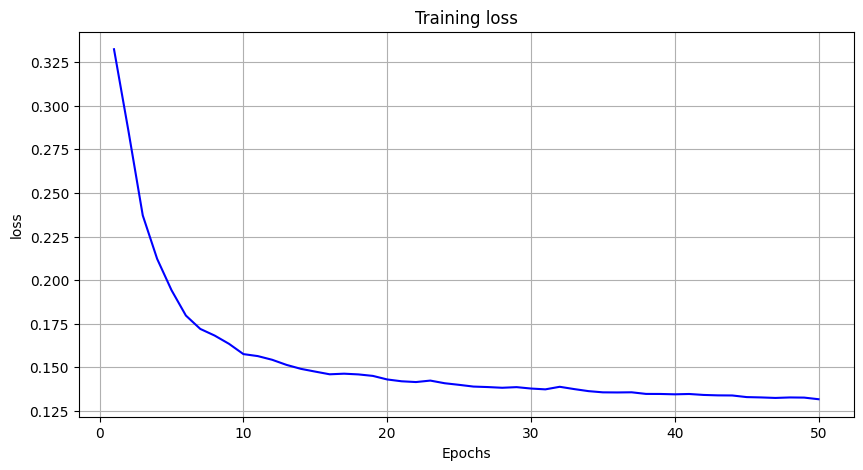

In [18]:
plot_loss(history_ae_simple.history['loss'])

In [20]:
autoencoder_simple.save('/content/drive/MyDrive/autoencoder_models/autoencoder_simple.keras')

## autoencoder_ssim

In [45]:
autoencoder_ssim = build_autoencoder(loss_func=ssim_loss, optimizer=keras.optimizers.Adam(learning_rate=0.001))
autoencoder_ssim.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 540, 540,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_109 (Conv2D) │ (None, 540, 540,  │        320 │ input_layer_11[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_110 (Conv2D) │ (None, 540, 540,  │      9,248 │ conv2d_109[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_22    │ (None, 270, 270,  │          0 │ conv2d_110[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_111 (Conv2D) │ (None, 270, 270,  │     18,496 │ max_pooling2d_22… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_112 (Conv2D) │ (None, 270, 270,  │     36,928 │ conv2d_111[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_23    │ (None, 135, 135,  │          0 │ conv2d_112[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_113 (Conv2D) │ (None, 135, 135,  │     73,856 │ max_pooling2d_23… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_114 (Conv2D) │ (None, 135, 135,  │    147,584 │ conv2d_113[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_22    │ (None, 270, 270,  │          0 │ conv2d_114[0][0]  │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_18      │ (None, 270, 270,  │          0 │ up_sampling2d_22… │
│ (Concatenate)       │ 192)              │            │ conv2d_112[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_115 (Conv2D) │ (None, 270, 270,  │    110,656 │ concatenate_18[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_116 (Conv2D) │ (None, 270, 270,  │     36,928 │ conv2d_115[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_23    │ (None, 540, 540,  │          0 │ conv2d_116[0][0]  │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_19      │ (None, 540, 540,  │          0 │ up_sampling2d_23… │
│ (Concatenate)       │ 96)               │            │ conv2d_110[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_117 (Conv2D) │ (None, 540, 540,  │     27,680 │ concatenate_19[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_118 (Conv2D) │ (None, 540, 540,  │      9,248 │ conv2d_117[0][0]

 Total params: 470,977 (1.80 MB)

 Trainable params: 470,977 (1.80 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
history_ae_ssim = autoencoder_ssim.fit(
    X_train, y_train,
    epochs=50,
    batch_size=8
)

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 16s 489ms/step - loss: 0.5241
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 502ms/step - loss: 0.1472
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 513ms/step - loss: 0.0663
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 515ms/step - loss: 0.0446
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 505ms/step - loss: 0.0334
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 495ms/step - loss: 0.0311
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 492ms/step - loss: 0.0235
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 493ms/step - loss: 0.0219
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 491ms/step - loss: 0.0173
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 493ms/step - loss: 0.0142
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 501ms/step - loss: 0.0127
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 507ms/step - loss: 0.0125
Epoch 13/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 505ms/step - loss: 0.0118
Epoch 14/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 502ms/step - loss: 0.0112
Epoch 15/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 499

In [47]:
autoencoder_ssim.evaluate(X_train, y_train)

5/5 ━━━━━━━━━━━━━━━━━━━━ 61s 6s/step - loss: 0.0040


0.003668367862701416

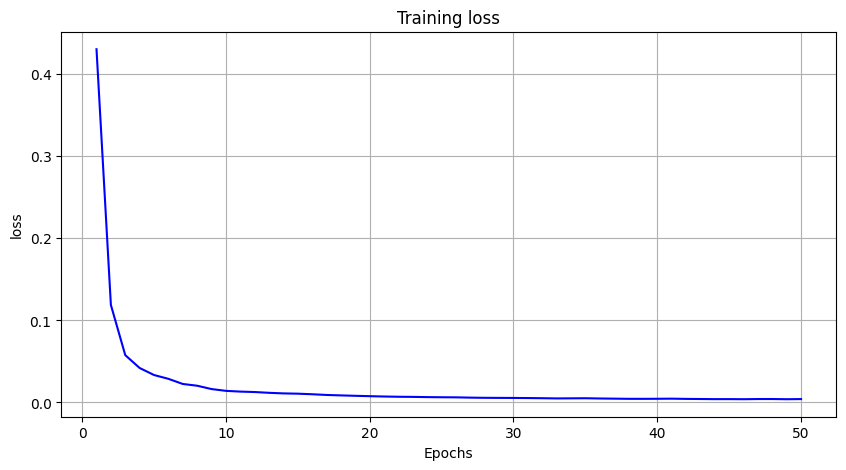

In [48]:
plot_loss(history_ae_ssim.history['loss'])

In [49]:
autoencoder_ssim.save('/content/drive/MyDrive/autoencoder_models/autoencoder_ssim.keras')

## autoencoder_bce_2

In [60]:
autoencoder_bce_2 = build_autoencoder(optimizer=keras.optimizers.Adam(learning_rate=0.001))
history_ae_bce_2 = autoencoder_bce_2.fit(
    X_train, y_train,
    epochs=50,
    batch_size=8
)

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 74s 480ms/step - loss: 0.5020
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 18s 490ms/step - loss: 0.2977
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 506ms/step - loss: 0.1853
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 502ms/step - loss: 0.1419
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 495ms/step - loss: 0.1285
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 489ms/step - loss: 0.1237
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 484ms/step - loss: 0.1189
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 481ms/step - loss: 0.1178
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 482ms/step - loss: 0.1143
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 488ms/step - loss: 0.1137
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 493ms/step - loss: 0.1161
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 499ms/step - loss: 0.1124
Epoch 13/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 499ms/step - loss: 0.1126
Epoch 14/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 500ms/step - loss: 0.1124
Epoch 15/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 493ms/s

In [61]:
autoencoder_bce_2.evaluate(X_train, y_train)

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 600ms/step - loss: 0.1106


0.10787919163703918

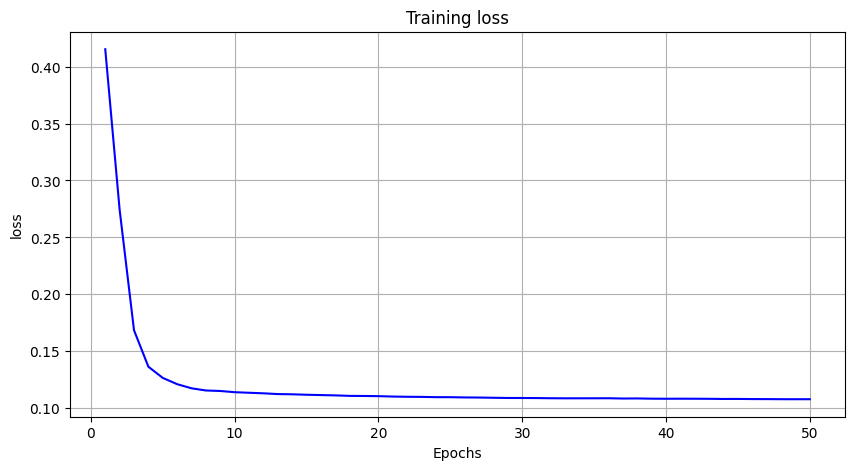

In [62]:
plot_loss(history_ae_bce_2.history['loss'])

In [63]:
autoencoder_bce_2.save('/content/drive/MyDrive/autoencoder_models/autoencoder_bce_2.keras')

## autoencoder_bce

In [79]:
autoencoder_bce = build_autoencoder_without_con(optimizer=keras.optimizers.Adam(learning_rate=0.003))
history_ae_bce = autoencoder_bce.fit(
    X_train, y_train,
    epochs=50,
    batch_size=8
)

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 423ms/step - loss: 0.5194
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 422ms/step - loss: 0.3098
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 417ms/step - loss: 0.2295
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 415ms/step - loss: 0.1961
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 417ms/step - loss: 0.1681
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 413ms/step - loss: 0.1499
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 413ms/step - loss: 0.1399
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 417ms/step - loss: 0.1347
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 421ms/step - loss: 0.1318
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 422ms/step - loss: 0.1294
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 420ms/step - loss: 0.1262
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 418ms/step - loss: 0.1256
Epoch 13/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 416ms/step - loss: 0.1241
Epoch 14/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 417ms/step - loss: 0.1219
Epoch 15/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 41

In [80]:
autoencoder_bce.evaluate(X_train, y_train)

5/5 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - loss: 0.1160


0.11326107382774353

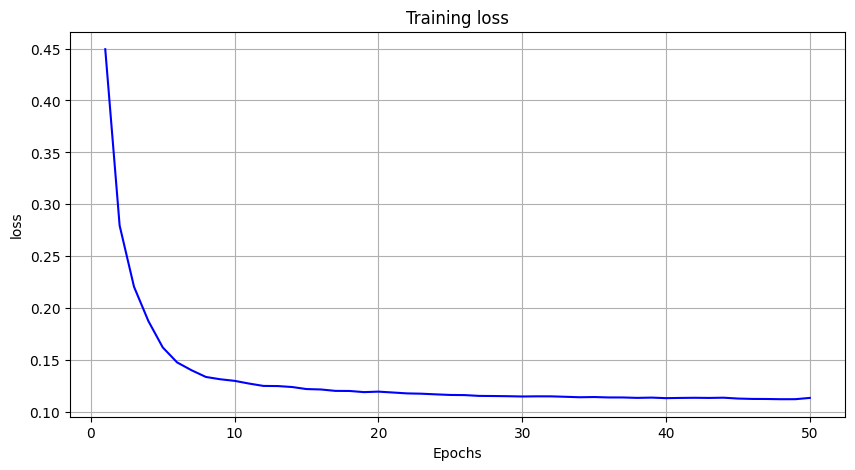

In [81]:
plot_loss(history_ae_bce.history['loss'])

In [82]:
autoencoder_bce.save('/content/drive/MyDrive/autoencoder_models/autoencoder_bce.keras')

## Тест модели на случайных картинках из обучающей выборки

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


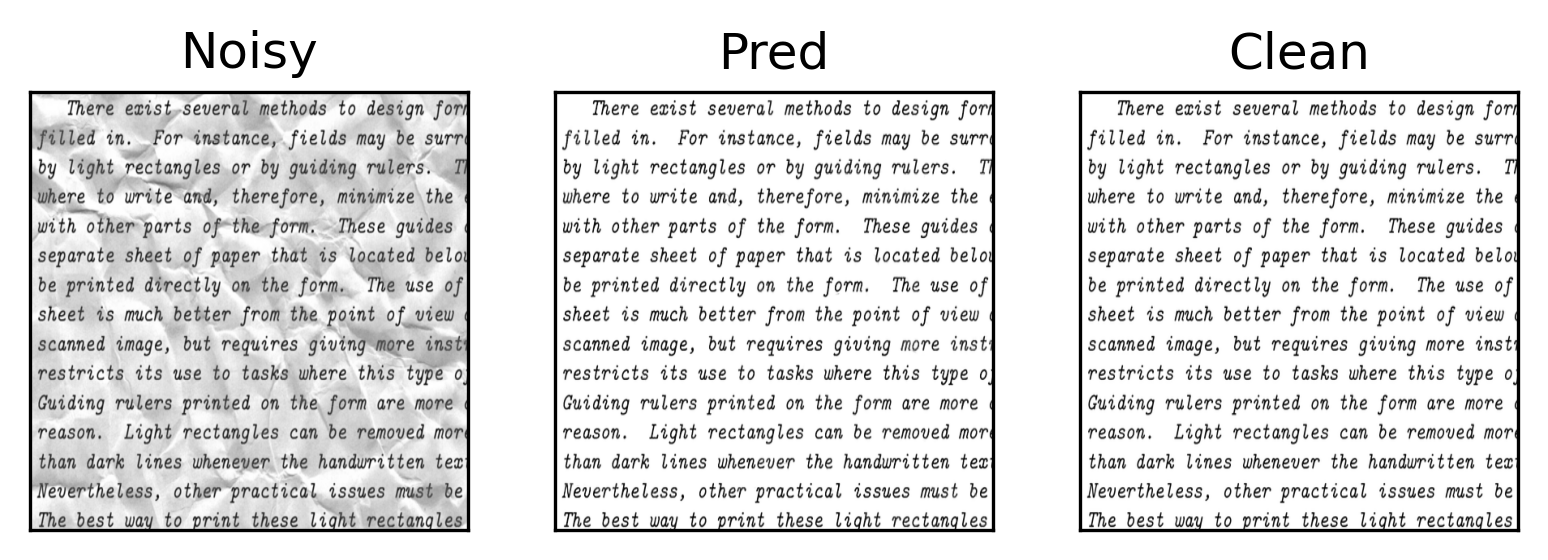

In [ ]:
i = np.random.randint(0, 144)
pred = autoencoder_bce_2.predict(X_train[i:i+1])
clean = y_train[i]

plt.figure(dpi=300)

ax = plt.subplot(1, 3, 1)
plt.imshow(X_train[i].squeeze(), cmap='gray')
plt.title("Noisy")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(1, 3, 2)
plt.imshow(pred.squeeze(), cmap='gray')
plt.title("Pred")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(1, 3, 3)
plt.imshow(clean.squeeze(), cmap='gray')
plt.title("Clean")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

## Тест модели на случайных картинках из тестовой выборки

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


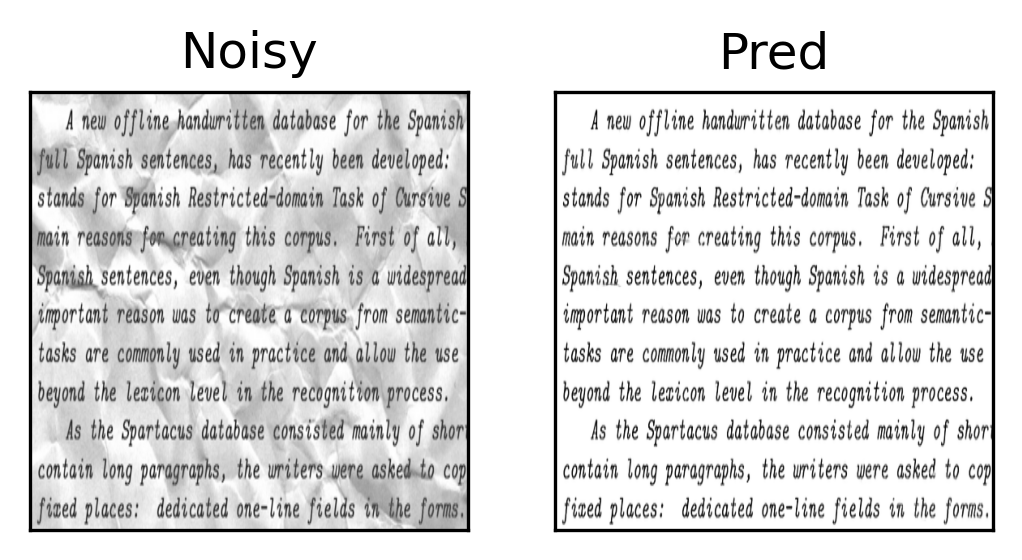

In [ ]:
i = np.random.randint(0, 72)
pred = autoencoder_bce_2.predict(X_test[i:i+1])

plt.figure(dpi=300)

ax = plt.subplot(1, 3, 1)
plt.imshow(X_test[i].squeeze(), cmap='gray')
plt.title("Noisy")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(1, 3, 2)
plt.imshow(pred.squeeze(), cmap='gray')
plt.title("Pred")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)